In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

plt.style.use("classic")

In [25]:
from sklearn.datasets import fetch_openml

# mnist data 불러오기
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [26]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

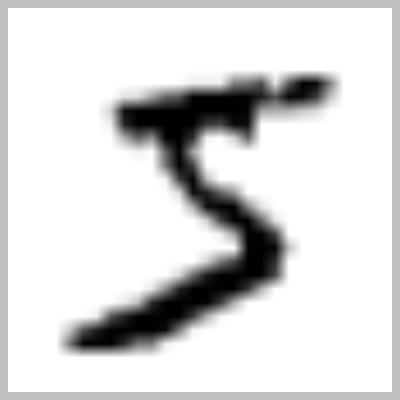

In [27]:
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [28]:
y = y.astype(np.uint8)

In [29]:
# train set 과 test set 의 분류
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [30]:
y_train_5 = (y_train  == 5)
y_test_5 = (y_test == 5)

In [31]:
# 이진 분류기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
print(f"train score : {sgd_clf.score(X_train, y_train_5):0.3f}")
print(f"test score : {sgd_clf.score(X_test, y_test_5):0.3f}")

train score : 0.968
test score : 0.964


In [32]:
# 교차 검증 구현하기
from math import radians
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5) :
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9648
0.9662285714285714
0.9661142857142857


In [33]:
# sklearn 을 활용한 교차검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3)

array([0.96417143, 0.96051429, 0.96428571])

### 평균적으로 95% 이상 올바른 예측을 한다.
### 이 모델이 성능이 좋은 것인지 비판적으로 바라본다.

In [34]:
# 모든 예측을 '5 아님' 으로 하는 모델
from sklearn.base import BaseEstimator

class Never5Classfier(BaseEstimator) :
    def fit(self, X, y=None) :
        return self
    def predict(self, X) :
        return np.zeros((len(X), 1), dtype=bool)

In [35]:
# 모든 예측을 '5 아님' 으로 하는 모델도 90% 이상의 성과를 낸다.
never_5_clf = Never5Classfier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91217143, 0.90954286, 0.90937143])

# 오차 행렬

In [36]:
from distutils import core
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [37]:
from sklearn.metrics import confusion_matrix

# '5 아님'인데 '5 아님' 으로 분류 , '5 아님' 인데 '5' 라고 분류
# '5' 인데 '5 아님' 으로 분류     , '5' 인데 '5' 로 분류

# 즉 약 4700 개의 '5' 중 4000 개의 '5' 만 정확하게 분류했다.
confusion_matrix(y_train_5, y_train_pred)

array([[46576,  1218],
       [  725,  3981]], dtype=int64)

In [38]:
from sklearn.metrics import precision_score, recall_score
# 정밀도(정확도) : 5로 분류한 것 중에 얼마나 정확하게 분류하였는지
print(precision_score(y_train_5, y_train_pred))
# 재현율 : '5' 인 것 중에 얼마나 정확하게 '5' 로 분류하였는지
print(recall_score(y_train_5, y_train_pred))

0.7657241777264858
0.8459413514662133


In [39]:
from sklearn.metrics import f1_score
# 정밀도와 재현율의 조화평균
f1_score(y_train_5, y_train_pred)

0.803836446239273

## 정밀도와 재현율은 trade-off 관계가 있다.
<br>

### 정밀도를 높이고 싶으면 확실한 것만 '5'로 분류한다.
### 다만 그렇게 되면 '5'이지만 '5'로 분류되지 않은 것이 많아져 재현율이 떨어진다.
<br>

### 재현율을 높이고 싶으면 애매해도 전부 '5'로 분류한다.
### 다만 그렇게 되면 '5' 가 아니지만 '5'로 분류된 것이 많아져 정밀도가 떨어진다.
---

# 임계값을 조절하여 정밀도와 재현율을 컨트롤하기

In [40]:
# decision function 값 구하기 (default 는 0 이상이면 '5' 로 분류한다.)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

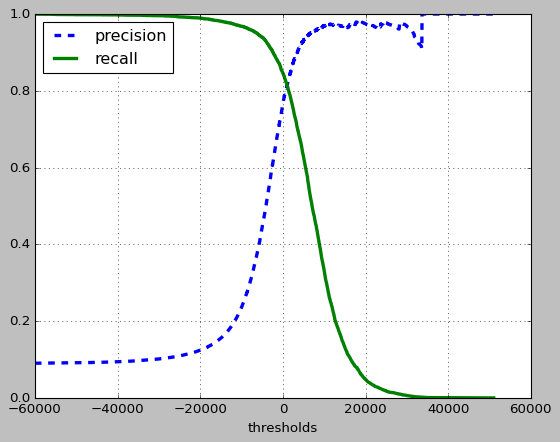

In [42]:
# 정밀도와 재현율 곡선 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds) :
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision', lw=3)
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall', lw=3)
    plt.xlabel('thresholds')
    plt.xlim([-60000,60000])
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [43]:
# 정밀도가 90% 넘는 값의 임계값
# argmax 는 최대값의 첫 index를 반환하므로 0.90 이 처음으로 초과되는 값의 index 를 반환하게 된다.
thresholds_90_precision = thresholds[np.argmax(precisions >= 0.90)]
thresholds_90_precision

3503.063183227059

In [44]:
y_train_pred_90 = (y_scores >= thresholds_90_precision)

In [45]:
print(f"precision : {precision_score(y_train_5, y_train_pred_90):0.3f}")
print(f"recall : {recall_score(y_train_5, y_train_pred_90):0.3f}")

precision : 0.900
recall : 0.703


# ROC 
## TPR(진짜 양성 비율) = TP/(FN+TP) == (재현율)
## FPR(거짓 양성 비율) = FP/(TN+FP)

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

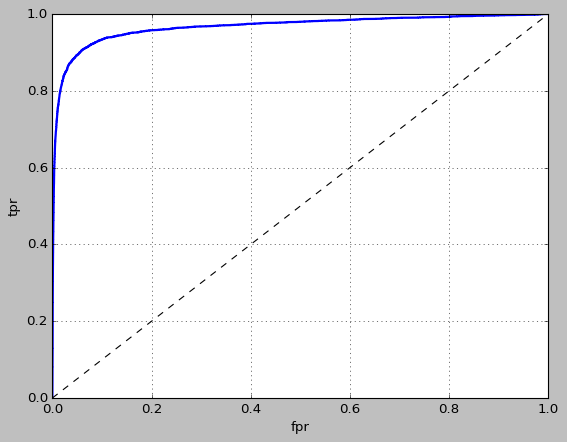

In [52]:
def plot_roc_curve(fpr, tpr, label=None) :
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel("fpr")
    plt.ylabel('tpr')
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)

In [51]:
# 곡선 아래의 면적을 측정한다.
# 완벽한 분류기는 면적이 1이고(꼭짓점이 좌상단 끝에 있는 경우)
# 완전한 랜덤분류기는 면적이 0.5이다.(꼭짓점이 정중앙에 있는 경우)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9667377922615583